<a href="https://colab.research.google.com/github/arushithapar/102117101-SESS_LE1/blob/main/102117101_ArushiDhingra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running the code, it is requested that you kindly upload the following files from the Drive Link.
https://drive.google.com/drive/folders/1Sdg1UUwM1b65cCZ-vtXu9ru3vZN4qyJz
*   DATASET.zip
*   _background_noise_.zip

The entire code will take around 45-50 Mins to execute on T4 GPU compute.



Downloading Original Dataset

In [ ]:
# Download the dataset
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

# Create a directory to extract the files into
!mkdir speech

# Extract the files into the new directory
!tar -xvzf speech_commands_v0.02.tar.gz -C speech


Import Libraries

In [ ]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
import librosa.display
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
# Path to the main directory where the files were extracted
data_dir = '/content/speech'

# List of directories (commands) to include in the analysis
commands = os.listdir(data_dir)
valid_commands = [cmd for cmd in commands if os.path.isdir(os.path.join(data_dir, cmd))
                  and cmd not in ['.', '..', '.config', '_background_noise_', '.ipynb_checkpoints', 'sample_data']]


Statistical Analysis

In [ ]:
# Function to compute and return mel-spectrogram statistics
def compute_mel_spectrogram_stats(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Compute mel-spectrogram statistics
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)

    return mean, std

# Update the analyze_dataset function to include mel-spectrogram statistics
def analyze_dataset(data_dir, commands):
    durations = []
    sample_rates = []
    files_per_command = {}
    snr_values = []
    mel_spectrogram_means = []
    mel_spectrogram_stds = []

    for command in commands:
        command_dir = os.path.join(data_dir, command)
        audio_files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]

        files_per_command[command] = len(audio_files)

        for file in audio_files:
            file_path = os.path.join(command_dir, file)
            y, sr = librosa.load(file_path, sr=None)

            # Calculate duration and sample rate
            durations.append(librosa.get_duration(y=y, sr=sr))
            sample_rates.append(sr)

            # Calculate Signal-to-Noise Ratio (SNR)
            signal_power = np.mean(y ** 2)
            noise_power = np.var(y - np.mean(y))
            snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
            snr_values.append(snr)

            # Calculate mel-spectrogram statistics
            mel_mean, mel_std = compute_mel_spectrogram_stats(file_path)
            mel_spectrogram_means.append(mel_mean)
            mel_spectrogram_stds.append(mel_std)

    return (np.array(durations), np.array(sample_rates), files_per_command,
            np.array(snr_values), np.array(mel_spectrogram_means), np.array(mel_spectrogram_stds))



In [ ]:
# Get dataset statistics
durations, sample_rates, files_per_command, snr_values,mel_means, mel_stds = analyze_dataset(data_dir, valid_commands)

# Print statistics
print(f"Total commands (words): {len(valid_commands)}")
print(f"Total audio files: {sum(files_per_command.values())}")
print(f"Average duration: {np.mean(durations):.2f} seconds")
print(f"Average sample rate: {np.mean(sample_rates):.2f} Hz")
print(f"Max duration: {np.max(durations):.2f} seconds")
print(f"Min duration: {np.min(durations):.2f} seconds")

# Print Signal-to-Noise Ratio statistics
print(f"Average SNR: {np.mean(snr_values):.2f} dB")
print(f"Max SNR: {np.max(snr_values):.2f} dB")
print(f"Min SNR: {np.min(snr_values):.2f} dB")

# Plot distribution of files per command
plt.figure(figsize=(12, 6))
plt.bar(files_per_command.keys(), files_per_command.values())
plt.title('Number of Audio Samples per Command')
plt.xlabel('Command')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show()

In [ ]:

# Print Mel-Spectrogram statistics
print(f"Average Mel-Spectrogram Mean: {np.mean(mel_means):.2f}")
print(f"Average Mel-Spectrogram Std Dev: {np.mean(mel_stds):.2f}")
print(f"Max Mel-Spectrogram Mean: {np.max(mel_means):.2f}")
print(f"Min Mel-Spectrogram Mean: {np.min(mel_means):.2f}")
print(f"Max Mel-Spectrogram Std Dev: {np.max(mel_stds):.2f}")
print(f"Min Mel-Spectrogram Std Dev: {np.min(mel_stds):.2f}")

# Plot distribution of mel-spectrogram means and stds
plt.figure(figsize=(12, 6))
plt.hist(mel_means, bins=30, alpha=0.7, label='Mel-Spectrogram Mean')
plt.hist(mel_stds, bins=30, alpha=0.7, label='Mel-Spectrogram Std Dev')
plt.legend()
plt.title('Distribution of Mel-Spectrogram Statistics')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


Feature Extraction

In [ ]:
# Define parameters
SAMPLE_RATE = 16000  # Standard sample rate for the dataset
MFCC_FEATURES = 20  # Number of MFCC coefficients
FRAME_COUNT = 32  # Number of frames
REMOVE_CATEGORY = '_background_noise_'  # Category to remove

In [ ]:
DATA_DIR = '/content/speech'

def extract_mfcc(file_path, n_mfcc=MFCC_FEATURES, frame_count=FRAME_COUNT):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Ensure the number of frames is consistent
    if mfccs.shape[1] < frame_count:
        # Pad the frames if there are fewer frames than expected
        mfccs = np.pad(mfccs, ((0, 0), (0, frame_count - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > frame_count:
        # Truncate the frames if there are more frames than expected
        mfccs = mfccs[:, :frame_count]

    return mfccs

def process_directory(data_dir):
    x_data = []
    y_labels = []
    label_map = {}
    label_index = 0

    # Collect all labels
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        # Check if it's a directory and not a hidden or unexpected folder
        if os.path.isdir(label_dir) and not label.startswith('.'):
            if label == REMOVE_CATEGORY:
                continue
            if label not in label_map:
                label_map[label] = label_index
                label_index += 1

    # Create OneHotEncoder for labels
    encoder = OneHotEncoder(sparse=False, categories=[list(range(len(label_map)))])

    # Extract MFCC features and labels
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir) and not label.startswith('.'):
            if label == REMOVE_CATEGORY:
                continue
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                if file_path.endswith('.wav'):
                    mfcc_features = extract_mfcc(file_path)
                    x_data.append(mfcc_features)
                    y_labels.append(label_map[label])

    # Convert labels to one-hot encoding
    y_labels = encoder.fit_transform(np.array(y_labels).reshape(-1, 1))

    return np.array(x_data), y_labels, label_map


In [ ]:
# Process the entire dataset
x_data, y_labels, label_map = process_directory(DATA_DIR)

# Reshape data to fit CNN input
x_data = x_data[..., np.newaxis]  # Add channel dimension

# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(x_data, y_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Print shapes of the resulting datasets
print(f'Training Features shape: {X_train.shape}')
print(f'Training Labels shape: {y_train.shape}')
print(f'Validation Features shape: {X_val.shape}')
print(f'Validation Labels shape: {y_val.shape}')
print(f'Test Features shape: {X_test.shape}')
print(f'Test Labels shape: {y_test.shape}')
print(f'Label map: {label_map}')

# Optionally: Save processed data to disk
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

Building the Model

In [ ]:
# Build the CNN model
model = Sequential()
model.add(InputLayer(input_shape=(MFCC_FEATURES, FRAME_COUNT, 1)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(512, kernel_size=(2, 2), activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_map), activation='softmax'))  # Adjusted to number of categories after removal
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1,
          validation_data=(X_val, y_val), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 911s 2s/step - accuracy: 0.2285 - loss: 2.7092 - val_accuracy: 0.7163 - val_loss: 1.0118
Epoch 2/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - accuracy: 0.6254 - loss: 1.2261 - val_accuracy: 0.8059 - val_loss: 0.6846
Epoch 3/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.7093 - loss: 0.9549 - val_accuracy: 0.8309 - val_loss: 0.5774
Epoch 4/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 921s 2s/step - accuracy: 0.7639 - loss: 0.7930 - val_accuracy: 0.8532 - val_loss: 0.5089
Epoch 5/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 896s 2s/step - accuracy: 0.7838 - loss: 0.7159 - val_accuracy: 0.8672 - val_loss: 0.4517
Epoch 6/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 901s 2s/step - accuracy: 0.8077 - loss: 0.6452 - val_accuracy: 0.8697 - val_loss: 0.4467
Epoch 7/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.8217 - loss: 0.6024 - val_accuracy: 0.8801 - val_loss: 0.4123
Epoch 8/10
579/579 ━━━━━━━━━━━━━━━━━━━━ 899s 2s/step - accuracy: 0.8324 - loss: 0.5622 - val_accu

In [ ]:
# Evaluate the model
score = model.evaluate(x=X_test, y=y_test)

for name, value in zip(model.metrics_names, score):
    print(name, value)

497/497 ━━━━━━━━━━━━━━━━━━━━ 46s 92ms/step - accuracy: 0.8924 - loss: 0.3659
loss 0.35718992352485657
compile_metrics 0.8944882154464722


In [ ]:
# Save the entire model to a file
model.save('model.h5')

497/497 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step


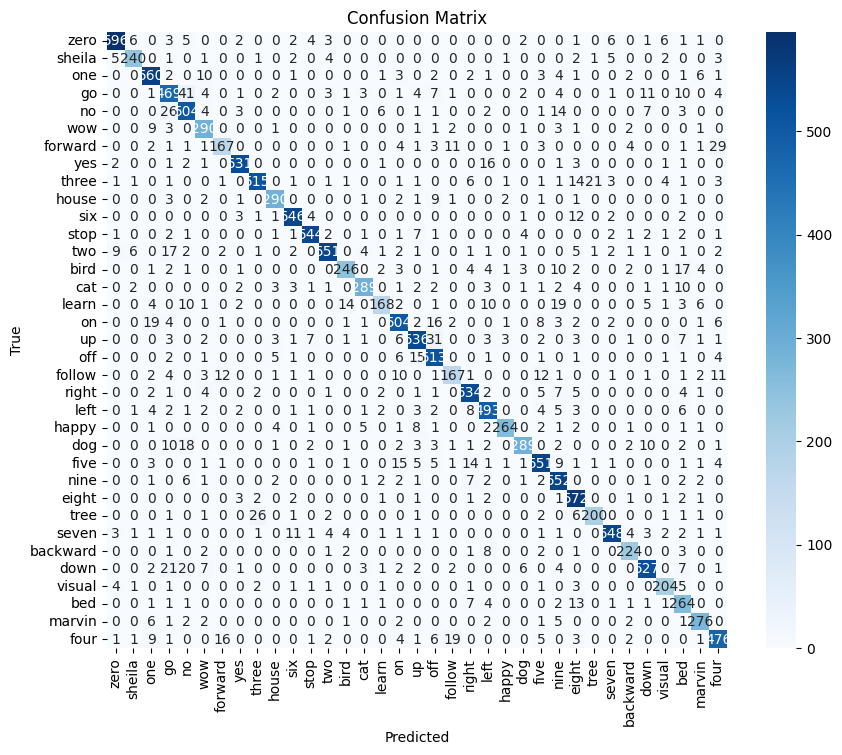

In [ ]:
# Step 1: Predict the classes for the test set
y_pred = model.predict(X_test)

# Convert predictions from one-hot encoded form to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Step 2: Create the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_map.keys()), yticklabels=list(label_map.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Generate the classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=list(label_map.keys()))

print("Classification Report:")
print(class_report)


Fine Tuning

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from collections import Counter

# Path to the ZIP file
zip_file_path = '/content/DATASET.zip'
# Directory where you want to extract the contents
extract_to_dir = '/content/'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print(f"Extracted files to: {extract_to_dir}")

# Path to the main directory where the files were extracted
data_dir = '/content/DATASET'

# List of directories (commands) to include in the analysis
commands = os.listdir(data_dir)
valid_commands = [cmd for cmd in commands if os.path.isdir(os.path.join(data_dir, cmd))
                  and cmd not in ['.', '..', '.config', '_background_noise_', '.ipynb_checkpoints', 'sample_data']]



Extracted files to: /content/


In [ ]:

# # Function to analyze dataset and gather additional metrics
def analyze_dataset_without_mel(data_dir, commands):
    durations = []
    sample_rates = []
    files_per_command = {}
    snr_values = []

    for command in commands:
        command_dir = os.path.join(data_dir, command)
        audio_files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]

        files_per_command[command] = len(audio_files)

        for file in audio_files:
            file_path = os.path.join(command_dir, file)
            try:
                y, sr = librosa.load(file_path, sr=None)
                # Calculate duration and sample rate
                durations.append(librosa.get_duration(y=y, sr=sr))
                sample_rates.append(sr)

                # Calculate Signal-to-Noise Ratio (SNR)
                signal_power = np.mean(y ** 2)
                noise_power = np.var(y - np.mean(y))
                snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
                snr_values.append(snr)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

    return np.array(durations), np.array(sample_rates), files_per_command, np.array(snr_values)


In [ ]:
# # Get dataset statistics
# durations, sample_rates, files_per_command, snr_values = analyze_dataset_without_mel(data_dir, valid_commands)

# # Print statistics
# if durations.size > 0:
#     print(f"Total commands (words): {len(valid_commands)}")
#     print(f"Total audio files: {sum(files_per_command.values())}")
#     print(f"Average duration: {np.mean(durations):.2f} seconds")
#     print(f"Average sample rate: {np.mean(sample_rates):.2f} Hz")
#     print(f"Max duration: {np.max(durations):.2f} seconds")
#     print(f"Min duration: {np.min(durations):.2f} seconds")

#     # Print Signal-to-Noise Ratio statistics
#     print(f"Average SNR: {np.mean(snr_values):.2f} dB")
#     print(f"Max SNR: {np.max(snr_values):.2f} dB")
#     print(f"Min SNR: {np.min(snr_values):.2f} dB")
# else:
#     print("No durations were collected. Please check your dataset.")

# # Plot distribution of files per command
# plt.figure(figsize=(12, 6))
# plt.bar(files_per_command.keys(), files_per_command.values())
# plt.title('Number of Audio Samples per Command')
# plt.xlabel('Command')
# plt.ylabel('Number of Samples')
# plt.xticks(rotation=90)
# plt.show()

Processing the Dataset Audios

In [ ]:
import os
import numpy as np
import librosa

def load_audio_files_from_subfolders(root_folder, sr=16000):
    """Load all audio files from subfolders, where each subfolder represents a command."""
    audio_samples = []
    file_names = []
    labels = []
    commands = os.listdir(root_folder)
    for command in commands:
        command_folder = os.path.join(root_folder, command)
        if os.path.isdir(command_folder):
            for file_name in os.listdir(command_folder):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(command_folder, file_name)
                    audio, _ = librosa.load(file_path, sr=sr)
                    audio_samples.append(audio)
                    file_names.append(file_name)
                    labels.append(command)
    return audio_samples, file_names, labels

def load_background_noise(folder_path, sr=16000):
    """Load all background noise files from a folder with the specified sample rate."""
    noise_samples = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            noise, _ = librosa.load(file_path, sr=sr)
            noise_samples.append(noise)
    return noise_samples

def resample_audio(y, original_sr, target_sr=16000):
    """Resample audio to the target sample rate."""
    if original_sr != target_sr:
        y = librosa.resample(y, orig_sr=original_sr, target_sr=target_sr)
    return y

def preprocess_audio(y, target_duration=1.0, sr=16000):
    """Normalize audio duration to the target duration."""
    target_length = int(target_duration * sr)
    if len(y) > target_length:
        y = y[:target_length]  # Trim
    else:
        y = np.pad(y, (0, target_length - len(y)))  # Pad
    return y

def add_background_noise(signal, noise_samples, snr_db):
    """Add background noise to the audio signal at a specified SNR."""
    # Ensure noise samples are the same length
    noise_samples = [noise[:len(signal)] if len(noise) > len(signal) else np.pad(noise, (0, len(signal) - len(noise))) for noise in noise_samples]

    # Randomly select a noise sample
    noise = noise_samples[np.random.randint(len(noise_samples))]

    # Compute signal and noise power
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)

    # Calculate required noise power for the given SNR
    snr_linear = 10 ** (snr_db / 10)
    target_noise_power = signal_power / snr_linear

    # Scale noise to achieve the desired SNR
    noise = noise * np.sqrt(target_noise_power / noise_power)

    # Add noise to the signal
    noisy_signal = signal + noise
    return noisy_signal

def preprocess_dataset(audio_samples, noise_samples, target_sr=16000, target_duration=1.0, snr_db=10):
    """Preprocess the entire dataset by resampling, normalizing duration, and adding background noise."""
    processed_samples = []
    for sample in audio_samples:
        # Resample and normalize duration
        sample = resample_audio(sample, original_sr=48000, target_sr=target_sr)
        sample = preprocess_audio(sample, target_duration, sr=target_sr)

        # Add background noise
        noisy_sample = add_background_noise(sample, noise_samples, snr_db)
        processed_samples.append(noisy_sample)

    return processed_samples

import soundfile as sf

def save_audio_samples(samples, file_names, labels, output_folder, sr=16000):
    """Save processed audio samples to the output folder, preserving the command subfolders."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    commands = set(labels)
    for command in commands:
        command_folder = os.path.join(output_folder, command)
        if not os.path.exists(command_folder):
            os.makedirs(command_folder)

    for sample, file_name, label in zip(samples, file_names, labels):
        command_folder = os.path.join(output_folder, label)
        output_path = os.path.join(command_folder, file_name)
        sf.write(output_path, sample, sr)


In [ ]:
# Path to the ZIP file
zip_file_path = '/content/_background_noise_.zip'
# Directory where you want to extract the contents
extract_to_dir = '/content/'

# Create the directory if it doesn't exist
os.makedirs(extract_to_dir, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)

print(f"Extracted files to: {extract_to_dir}")


Extracted files to: /content/


In [ ]:
# Paths to your folders
audio_folder = '/content/DATASET'
background_noise_folder = '/content/_background_noise_'
output_folder = '/content/Output'

# Load audio files and background noise
audio_samples, audio_file_names, audio_labels = load_audio_files_from_subfolders(audio_folder)
noise_samples = load_background_noise(background_noise_folder)

In [ ]:
snr_db = 10
processed_audio_samples = preprocess_dataset(audio_samples, noise_samples, target_sr=16000, target_duration=1.0, snr_db=snr_db)

save_audio_samples(processed_audio_samples, audio_file_names, audio_labels, output_folder)

Stats of Processed Dataset

In [ ]:
# # Get dataset statistics
# data_dir = '/content/Output'
# durations, sample_rates, files_per_command, snr_values = analyze_dataset(data_dir, valid_commands)

# # Print statistics
# if durations.size > 0:
#     print(f"Total commands (words): {len(valid_commands)}")
#     print(f"Total audio files: {sum(files_per_command.values())}")
#     print(f"Average duration: {np.mean(durations):.2f} seconds")
#     print(f"Average sample rate: {np.mean(sample_rates):.2f} Hz")
#     print(f"Max duration: {np.max(durations):.2f} seconds")
#     print(f"Min duration: {np.min(durations):.2f} seconds")

#     # Print Signal-to-Noise Ratio statistics
#     print(f"Average SNR: {np.mean(snr_values):.2f} dB")
#     print(f"Max SNR: {np.max(snr_values):.2f} dB")
#     print(f"Min SNR: {np.min(snr_values):.2f} dB")
# else:
#     print("No durations were collected. Please check your dataset.")

# # Plot distribution of files per command
# plt.figure(figsize=(12, 6))
# plt.bar(files_per_command.keys(), files_per_command.values())
# plt.title('Number of Audio Samples per Command')
# plt.xlabel('Command')
# plt.ylabel('Number of Samples')
# plt.xticks(rotation=90)
# plt.show()

Finetuning the Model

In [ ]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

# Constants
MFCC_FEATURES = 20   # Number of MFCC coefficients
FRAME_COUNT = 32     # Number of frames
SAMPLE_RATE = 16000  # Target sample rate for MFCC
REMOVE_CATEGORY = '_background_noise_'  # Category to remove
OUTPUT_DIR = '/content/Output'  # Preprocessed data directory
MODEL_PATH = '/content/model.h5'  # Path to saved .h5 model

# Step 1: MFCC Extraction Code (as before)
def extract_mfcc(file_path, n_mfcc=MFCC_FEATURES, frame_count=FRAME_COUNT):
    """Extract MFCC features and ensure consistent frame count."""
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    if mfccs.shape[1] < frame_count:
        mfccs = np.pad(mfccs, ((0, 0), (0, frame_count - mfccs.shape[1])), mode='constant')
    elif mfccs.shape[1] > frame_count:
        mfccs = mfccs[:, :frame_count]

    return mfccs

def process_directory(data_dir):
    x_data = []
    y_labels = []
    label_map = {}
    label_index = 0

    # Collect all labels
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        # Check if it's a directory and not a hidden or unexpected folder
        if os.path.isdir(label_dir) and not label.startswith('.'):
            if label == REMOVE_CATEGORY:
                continue
            if label not in label_map:
                label_map[label] = label_index
                label_index += 1

    # Create OneHotEncoder for labels
    encoder = OneHotEncoder(sparse=False, categories=[list(range(len(label_map)))])

    # Extract MFCC features and labels
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir) and not label.startswith('.'):
            if label == REMOVE_CATEGORY:
                continue
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                if file_path.endswith('.wav'):
                    mfcc_features = extract_mfcc(file_path)
                    x_data.append(mfcc_features)
                    y_labels.append(label_map[label])

    # Convert labels to one-hot encoding
    y_labels = encoder.fit_transform(np.array(y_labels).reshape(-1, 1))

    return np.array(x_data), y_labels, label_map

In [ ]:
# Step 2: Load preprocessed data
X, y, label_map = process_directory(OUTPUT_DIR)
X = X[..., np.newaxis]  # Reshape to include channel dimension

# Step 3: Load Pre-Trained Model
model = tf.keras.models.load_model(MODEL_PATH)

# Step 4: Fine-Tuning the Model
# Adjusting only the last few layers
for layer in model.layers[:-3]:  # Freeze all but the last 3 layers for fine-tuning
    layer.trainable = False

# Recompile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Fine-tune the model
history = model.fit(X, y, batch_size=32, epochs=5, validation_split=0.2)

# Step 5: Save the fine-tuned model
model.save('speech_command_finetuned.h5')

In [ ]:
# Optional: Evaluate the fine-tuned model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy after fine-tuning: {test_acc}")

Test Accuracy before Fine-Tuning: 89%

---

Test Accuracy before Fine-Tuning: 70%

---

